In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class ContinuousSignal:
    def __init__(self, func):
        self.func = func

    def get_value_at_time(self, time):
        # Get the value of the signal at a specific time
        return self.func(time)

    def add(self, other):
        # Define a method to add another signal to this one
        def add_func(x):
            return self.func(x) + other.func(x)
        new_signal = ContinuousSignal(add_func)
        return new_signal

    def shift_signal(self, shift):
        # Define a method to shift the signal by a specific amount
        def shifted_func(x):
            return self.func(x - shift)
        new_signal = ContinuousSignal(shifted_func)
        return new_signal

    def multiply(self, other):
        # Define a method to multiply this signal with another
        def multiplied_func(x):
            return self.func(x) * other.func(x)
        new_signal = ContinuousSignal(multiplied_func)
        return new_signal

    def multiply_const_factor(self, scaler):
        # Define a method to multiply the signal by a scalar factor
        def scaled_func(x):
            return self.func(x) * scaler
        new_signal = ContinuousSignal(scaled_func)
        return new_signal

    def plot(self, start, end, label):
        # Generate the x values for plotting
        x = np.linspace(start, end, 1000)
        # Get the corresponding y values by applying the signal function
        y = self.func(x)
        
        # Plot the signal with a label
        plt.plot(x, y, label=label)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.grid(True)

    @staticmethod
    def show():
        # Show all the plots
        plt.legend()
        plt.show()

# Define the unit impulse function separately
def unit_impulse(x):
    delta = 0.05
    impulse = np.zeros_like(x)  # Create an array of zeros with the same shape as x
    impulse[(x >= 0) & (x < delta)] = 1 / delta  # Set the impulse value where the condition is met
    return impulse


def unit_step(x):
    return np.where(x >= 0, 1, 0)

contSig=ContinuousSignal(unit_step)
contSig.plot(-10,10,'unit step')
contSig2=contSig.shift_signal(3)
contSig2.plot(-10,10,'unit step shifted by 3')

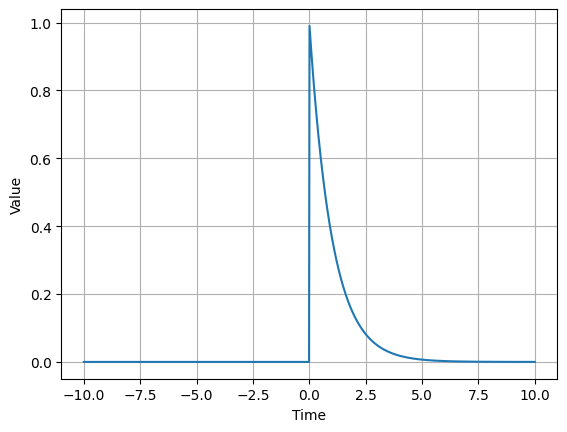

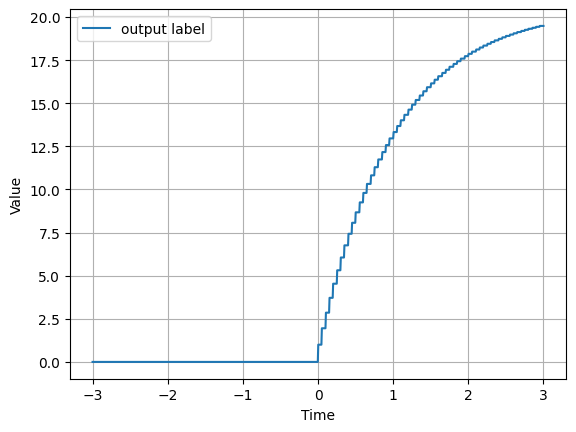

In [94]:
class LTI_Continuous :
    def __init__(self,impulse_response):
        self.impulse_response=impulse_response
        self.INF=10
        
    def linear_combination_of_impulses(self,input_signal,delta):
        decomposed=[]
        
        for i in np.arange(-self.INF, self.INF + 1, delta):
            coefficient=input_signal.get_value_at_time(i)
            
            if coefficient!=0:
                #kebol banailam unit impulse
                impulse=ContinuousSignal(unit_impulse)
                #shift korbo i amount e.because amr shifted signal lagbe
                shiftedImpulse=impulse.shift_signal(i)
                
                                
                #decomposed er moddhe push korbo amr pair(shifted_unit_impulse,coeff)
                
                decomposed.append((shiftedImpulse,coefficient,i))
                scaled_impulse = shiftedImpulse.multiply_const_factor(coefficient)
                # scaled_impulse.plot(-10,10,label='')
                # plt.figure()

        return decomposed
    def zero(self,x):
        return 0
        
    def output_approx(self,signal,delta):
        # notun cont signal banailam jekhane shob values 0
        result=ContinuousSignal(self.zero)
        
        #decomposed signal gula ber korlam input signal er
        
        decomposed=self.linear_combination_of_impulses(signal,delta)
        
        #prottekta decomposed signal er jonno output ber korbo by shifting impulse response and mutlipyling by that constant factor
        
        for decomposed_signal,coefficient,i in decomposed:
            
            response=self.impulse_response
            shifted_response=response.shift_signal(i)
            component=shifted_response.multiply_const_factor(coefficient)
            result=result.add(component)
        return result 
    def show(self):
        self.impulse_response.plot(-10,10,'Impulse Response')
        

def myFunc(x):
    return np.where(x > 0, np.exp(-x), 0)

signal = ContinuousSignal(myFunc)
signal.plot(-10,10,"Input Signal")
plt.figure()
response = ContinuousSignal(unit_step)

system = LTI_Continuous(response)
output = system.output_approx(signal,0.05)
# system.linear_combination_of_impulses(signal,0.05)
output.plot(-3,3,"output label")
ContinuousSignal.show()
